In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# Library for registration and others
!pip install SimpleITK-SimpleElastix

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.7 MB/s eta 0:00:00


In [ ]:
#Importing libraries to be used
import cv2
import numpy as np                                            
import matplotlib.pyplot as plt                 
from google.colab.patches import cv2_imshow
import nibabel as nib
import pandas as pd
import os
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy.signal import medfilt
import skimage
import tensorflow as tf
import torchvision.transforms.functional as TF
from PIL import Image
from tensorflow import keras
from skimage import filters
from skimage.util import random_noise
from tensorflow.keras import layers
from skimage import exposure
import pickle 

In [ ]:
# dataset parameters
N_VOLUMES = 10
IMAGE_SIZE = (256, 128, 256)

# Directories
input_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/'
train_directory = input_directory+'Training_Set' 
val_directory = input_directory+'Validation_Set'
test_directory = input_directory+'Test_Set'
test_results_dl = input_directory+ 'Test Results DL'
models_directory= input_directory +'models'

# network parameters
N_CLASSES = 4
N_INPUT_CHANNELS = 1
PATCH_SIZE = (64, 64)
PATCH_STRIDE = (32, 32)
DROPOUT_RATE=0.3

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 10
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'SGD'
LOSS = 'categorical_crossentropy'

In [ ]:
# Visualize 2D Slice from 3D Image
def slice_show(image, slice_no, title):
    """
    Inputs: 
    image => Nifti Image that need to be visualized,
    slice_no => Slice Number from 1 to 48
    title => The title of the Image
    nibflag => Boolean variable to know whether the image was loaded with nibabel (1) or simpleITK library (0).
    
    output: Plot Image.

    """ 
    plt.figure()
    plt.axis('off')
    plt.title(title)
    plt.imshow(image[slice_no,:,:], cmap='gray') 

In [ ]:
def SITKtoArray(itk_image):
      """
    Function to convert SITK image to Array 
    Inputs: 
    itk_image: SimpleITK image
    
    output: Image in array format

    """
  return sitk.GetArrayFromImage(itk_image)

In [ ]:
def ArraytoSITK(array, reference_image):
  """
  Function to convert Numpy Array to Sitk Image
  Inputs: 
  array => numpy array that needs to be converted,
  reference_image => image which metadata will be copied

  output: Converted sitk image.

  """
  image= sitk.GetImageFromArray(array)
  image.CopyInformation(reference_image)
  return image

In [ ]:
def load_data(directory):
  """
  Function to load data with desired format from a given directory.
  Inputs: 
  directory => either train or val or test data directory,

  output: 3 lists containing images, labels and their names.

  """ 

  images = []
  labels = []
  images_names= []
  
  for folders in sorted(os.listdir(directory)):
    images_names.append(folders)
    images_directory = os.path.join(directory, folders)
    for files in sorted(os.listdir(images_directory)):    
      if '_seg' in files:
        # Accessing the labels/ground truths
        label_paths = os.path.join(images_directory, files)
        label_paths = SITKtoArray(sitk.ReadImage(label_paths))
        labels.append(label_paths)

      else:
        image_paths = os.path.join(images_directory, files)
        image_paths= SITKtoArray(sitk.ReadImage(image_paths))
        images.append(image_paths)
  return np.array(images), np.array(labels), np.array(images_names)

In [ ]:
def load_paths(directory):
    """
  Function to load data with desired format from a given directory.
  Inputs: 
  directory => either train or val or test data directory,

  output: 3 lists containing images, labels and their names.

  """ 
  
  images = []
  labels = []
  images_names= []
  
  for folders in sorted(os.listdir(directory)):
    images_names.append(folders)
    images_directory = os.path.join(directory, folders)
    for files in sorted(os.listdir(images_directory)):    
      if '_seg' in files:
        # Accessing the labels/ground truths
        label_paths = os.path.join(images_directory, files)
        labels.append(label_paths)

      else:
        image_paths = os.path.join(images_directory, files)
        images.append(image_paths)
  return images, labels,images_names

In [ ]:
def diceScoreSimilarity(segmented_image, ground_truth):
  
    """
    Inputs: 
    segmented_image => Segmeneted image,
    ground_truth => ground truth,

    output: Dice Score for all the three classes separately.

    """ 
           
    # Compute DICE
    def dice(SI, GT):
      #   2 * TP / (FN + (2 * TP) + FP)
      intersection = np.logical_and(SI, GT)
      return 2. * intersection.sum() / (SI.sum() + GT.sum())
    
    # Dice  for CSF
    Seg_CSF = (segmented_image == 1)
    GT_CSF = (ground_truth == 1)
    dice_CSF = dice(Seg_CSF, GT_CSF)
    # Dice  for GM
    Seg_GM = (segmented_image == 2)
    GT_GM = (ground_truth == 2)
    dice_GM = dice(Seg_GM, GT_GM)
    # Dice  for WM
    Seg_WM = (segmented_image == 3)
    GT_WM = (ground_truth == 3)
    dice_WM = dice(Seg_WM, GT_WM)


    return dice_CSF, dice_WM, dice_GM

In [ ]:
#Loading training and validation images
train_images, train_labels, train_names = load_data(train_directory)
val_images, val_labels, val_names = load_data(val_directory)

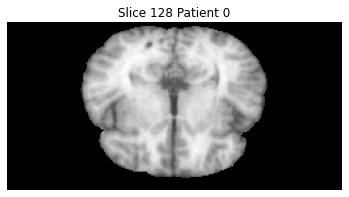

In [ ]:
slice_show(train_images[0],128,'Slice 128 Patient 0')

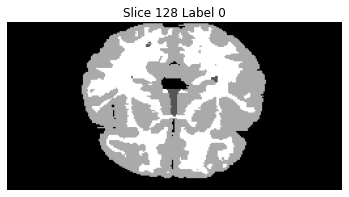

In [ ]:
slice_show(train_labels[0],128,'Slice 128 Label 0')

In [ ]:
#Loading training and validation preprocessed images from the Multi-Atlas approach
train_preprocessed_images= np.array(pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/train_preprocessed_images.sav', 'rb')))
val_preprocessed_images= np.array(pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/val_preprocessed_images.sav', 'rb')))

In [ ]:
train_ppi=[]
for i in train_preprocessed_images: 
  train_ppi.append(np.moveaxis(i,-1,0))
train_ppi= np.array(train_ppi)

In [ ]:
val_ppi=[]
for i in val_preprocessed_images: 
  val_ppi.append(np.moveaxis(i,-1,0))
val_ppi= np.array(val_ppi)

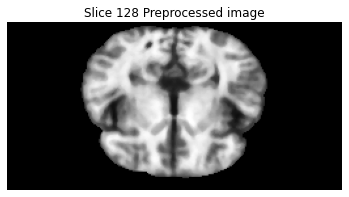

In [ ]:
slice_show(train_ppi[0],128,'Slice 128 Preprocessed image')

In [ ]:
#Taking 8 training images for training and 2 for validation purposes during training
train_images_unet, train_labels_unet, train_images_names_unet = train_ppi[0:8], train_labels[0:8], train_names[0:8]
val_images_unet, val_labels_unet, val_images_names_unet = train_ppi[8:10], train_labels[8:10], train_names[8:10]

In [ ]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    """
  Function to create unet model
  Inputs: 
  directory => img_size = size of the patch
  n_classes => number of classes
  n_input_channels => number of input channels
  scale => scale

  output: unet model

  """ 
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    max3 = layers.MaxPooling2D((2, 2))(conv3)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    concat1 = layers.concatenate([conv3, up1], axis=-1)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat1)
    
    up2 = layers.UpSampling2D((2, 2))(conv4)
    concat2 = layers.concatenate([conv2, up2], axis=-1)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat2)
    
    up3 = layers.UpSampling2D((2, 2))(conv5)
    concat3 = layers.concatenate([conv1, up3], axis=-1)

    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat3)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

In [ ]:
def extract_patches(x, patch_size, patch_stride) :
    """
  Function to extract patches
  Inputs: 
  x: input image tensor
  patch_size: patch size to extract
  patch_stride: patch stride for the extraction

  output: extracted patches from the image

  """ 
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [ ]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES):
  """
  Function to extract useful patches from the images 
  Inputs: 
  volumes: input intensity images
  labels: input label images
  image_size: size of the input image
  patch size: patch size to be extracted
  stride: stride size to be used for the extraction
  threshold: content percentage inside the patch
  num_classes: number of classes for the segmentation


  output: vol_patches: extracted useful patches
  seg_patches: extracted useful patches from the segmentation (labels)

  """ 
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])

  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])

  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  seg_patches = seg_patches[useful_patches]

  seg_patches = tf.keras.utils.to_categorical(
    seg_patches, num_classes=N_CLASSES, dtype='float32')
  
  return (vol_patches, seg_patches)

In [ ]:
#Patch extraction
(train_patches, train_patches_seg) = extract_useful_patches(train_images_unet, train_labels_unet)
(val_patches, val_patches_seg) = extract_useful_patches(val_images_unet, val_labels_unet)

In [ ]:
#Model training
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)
]

segnet = get_unet()
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
history= segnet.fit(
    x=train_patches, 
    y=train_patches_seg,
    validation_data=(val_patches, val_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/200
151/151 [==============================] - 20s 64ms/step - loss: 1.2042 - val_loss: 0.9330
Epoch 2/200
151/151 [==============================] - 8s 55ms/step - loss: 0.6227 - val_loss: 0.4137
Epoch 3/200
151/151 [==============================] - 8s 56ms/step - loss: 0.4241 - val_loss: 0.3919
Epoch 4/200
151/151 [==============================] - 9s 57ms/step - loss: 0.3867 - val_loss: 0.4230
Epoch 5/200
151/151 [==============================] - 8s 55ms/step - loss: 0.3633 - val_loss: 0.3268
Epoch 6/200
151/151 [==============================] - 8s 55ms/step - loss: 0.3451 - val_loss: 0.2970
Epoch 7/200
151/151 [==============================] - 8s 55ms/step - loss: 0.3365 - val_loss: 0.2894
Epoch 8/200
151/151 [==============================] - 8s 55ms/step - loss: 0.3249 - val_loss: 0.3430
Epoch 9/200
151/151 [==============================] - 8s 55ms/step - loss: 0.3151 - val_loss: 0.2924
Epoch 10/200
151/151 [==============================] - 8s 55ms/step - loss: 0.31

In [ ]:
test_images= val_ppi.copy()
test_labels = val_labels.copy()

In [ ]:
#Compile and load model weights
segnet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.load_weights('model.h5')

In [ ]:
#Save model
model_json = segnet.to_json()
with open(models_directory+"/2DUNET_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize model to JSON
model_json = segnet.to_json()
with open(models_directory+"/2DUNET_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
segnet.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open(models_directory+"/2DUNET_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer=OPTIMISER, loss=LOSS)

In [ ]:
testing_volumes_processed=[]
for i in test_images: 
  a= i.reshape([-1,IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
  testing_volumes_processed.append(a)

In [ ]:
testing_labels_processed=[]
for i in test_labels: 
  a= i.reshape([-1,IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
  a= tf.keras.utils.to_categorical(a, num_classes=4, dtype='float32')
  testing_labels_processed.append(a)

In [ ]:
#Predictions
predictions=[]
for k in testing_volumes_processed:
  prediction = loaded_model.predict(x=k)
  prediction = np.argmax(prediction, axis=3)
  predictions.append(prediction)

8/8 [==============================] - 17s 2s/step


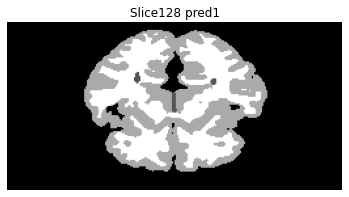

In [ ]:
slice_show(predictions[0],128,'Slice128 pred1')

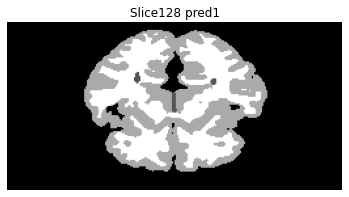

In [ ]:
slice_show(predictions[0],128,'Slice128 pred1')

Calculation of dice scores for validation images 

In [ ]:
dice_scores=[]
for i in range(len(predictions)): 
  dice_CSF,dice_GM, dice_WM =  diceScoreSimilarity(predictions[i], test_labels[i])
  dice_scores.append([dice_CSF,dice_GM,dice_WM])
  print("For patient {}, the Dice Score for CSF, GM and WM were {:.4f},{:.4f},{:.4f}, respectively".format(i+1,dice_CSF, dice_GM, dice_WM))
dice_scores= np.array(dice_scores)
mean_dice= np.mean(dice_scores,axis=0)
print("In average, the dice score for CSF, GM and WM are {:.4f},{:.4f},{:.4f}, respectively".format(mean_dice[0],mean_dice[1],mean_dice[2]))

For patient 1, the Dice Score for CSF, GM and WM were 0.8028,0.9201,0.9067, respectively
For patient 2, the Dice Score for CSF, GM and WM were 0.8497,0.9048,0.9009, respectively
For patient 3, the Dice Score for CSF, GM and WM were 0.7704,0.8703,0.9102, respectively
For patient 4, the Dice Score for CSF, GM and WM were 0.8438,0.9109,0.9249, respectively
For patient 5, the Dice Score for CSF, GM and WM were 0.8566,0.8625,0.9135, respectively
In average, the dice score for CSF, GM and WM are 0.8247,0.8937,0.9112, respectively


8/8 [==============================] - 0s 67ms/step


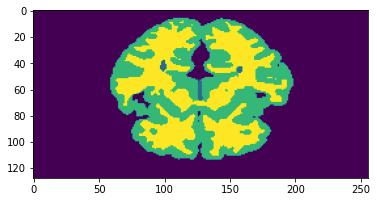

In [ ]:
#Example of prediction for patient 1, image IBSR_12
prediction = segnet.predict(x=testing_volumes_processed[0])

prediction = np.argmax(prediction, axis=3)

plt.imshow(prediction[128, :, :])

Producing final results for test set of unseen data

In [ ]:
final_test_images, final_test_labels, final_test_names = load_data(test_directory)



In [ ]:
final_test_preprocessed_images= np.array(pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/test_preprocessed_images.sav', 'rb')))


In [ ]:
final_test_ppi=[]
for i in final_test_preprocessed_images: 
  final_test_ppi.append(np.moveaxis(i,-1,0))
final_test_ppi= np.array(final_test_ppi)

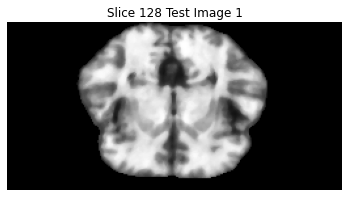

In [ ]:
slice_show(final_test_ppi[0],128,'Slice 128 Test Image 1')

In [ ]:
final_testing_volumes_processed=[]
for i in final_test_ppi: 
  a= i.reshape([-1,IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
  final_testing_volumes_processed.append(a)

In [ ]:
final_predictions=[]
for k in final_testing_volumes_processed:
  prediction = loaded_model.predict(x=k)
  prediction = np.argmax(prediction, axis=3)
  final_predictions.append(prediction)

8/8 [==============================] - 0s 59ms/step


Predictions for submission

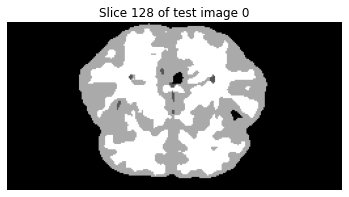

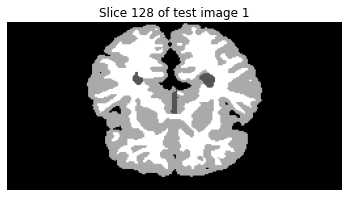

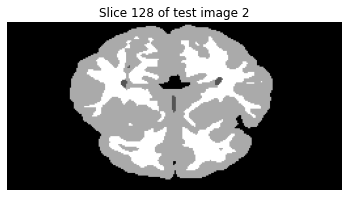

In [ ]:
#Showing slice 128 for all of the generated masks
for k in range(len(final_predictions)): 
  slice_show(final_predictions[k], 128, 'Slice 128 of test image {}'.format(k))

Exporting the images

In [ ]:
#Test images paths
test_paths,_,_ =load_paths(test_directory)

In [ ]:
#Exporting imagesfor submission
for element in range(len(final_predictions)): 
  reference_image = sitk.ReadImage(test_paths[element])
  sitk_image= ArraytoSITK(final_predictions[element].astype(np.int16), reference_image)
  sitk.WriteImage(sitk_image,test_results_dl+'/'+final_test_names[element]+'_seg.nii.gz')
